# Forecasting Future Sales Using Machine Learning

Forecasting future sales of a product offers many advantages. Predicting future sales of a product helps a company manage the cost of manufacturing and marketing the product. In this notebook, I will try to you through the task of future sales prediction with machine learning using Python.

In [1]:
# EDA Libraries:

import pandas as pd
import numpy as np

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# LSTM (Long Short Term Memory):

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
#from keras import np_utils
from keras.layers import LSTM


# ARIMA Model:

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

# SVM Model
from sklearn.svm import SVR


import pickle
import warnings


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## **Loading Dataset & Data Exploration (EDA)** 

   The first step is to load the data and transform it into a structure that we will then use for each of our models. In its raw form, each row of data represents a single day of sales at one of ten stores. Our goal is to predict monthly sales, so we will first consolidate all stores and days into total monthly sales.

In [3]:
dataset = pd.read_csv('../input/sample-model-data/sample_model_data.csv')
df = dataset.copy()
df.head()

,date,store,item,sales
0,1/1/2013,1,1,13.0
1,1/2/2013,1,1,11.0
2,1/3/2013,1,1,14.0
3,1/4/2013,1,1,13.0
4,1/5/2013,1,1,10.0


In [4]:
def load_data(file_name):
    """Returns a pandas dataframe from a csv file."""
    return pd.read_csv(file_name)

In [5]:
sales_data = load_data('../input/sample-model-data/sample_model_data.csv')
df_s = sales_data.copy()
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912998 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [6]:
import datetime
df_s['date'] = pd.to_datetime(df_s['date'])

In [7]:
df_s.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63.0
912996,2017-12-28,10,50,59.0
912997,2017-12-29,10,50,74.0
912998,2017-12-30,10,50,62.0
912999,2017-12-31,10,50,82.0


In [8]:
# To view basic statistical details about dataset:

df_s['sales'].describe()

count    912998.00000
mean         55.42977
std          29.80060
min           1.00000
25%          32.00000
50%          50.00000
75%          73.00000
max         234.00000
Name: sales, dtype: float64

 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Sales seem to be unbalanced!
    </h4>
  </div>

<Axes: >

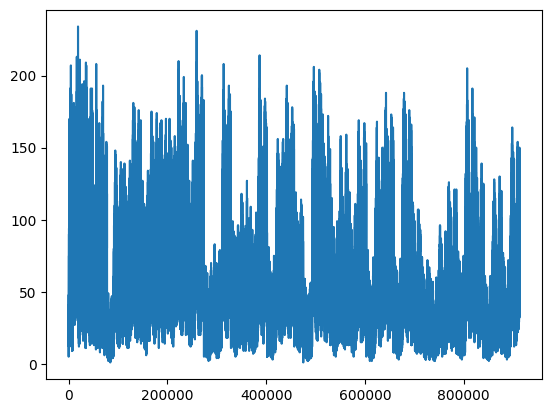

In [9]:
df_s['sales'].plot()


> Returns a dataframe where each row represents total sales for a given month. Columns include 'date' by month and 'sales'.
    

In [10]:
def month_year_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column: 
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
   # Sum sales per month: 
    data = data.groupby('date')['sales'].sum().reset_index()
    try:
        data.date = pd.to_datetime(data.date)
    except:
        print('This date is in the error: ', data.date)
        
    return data
    

In [11]:
m_df = month_year_sales(df_s,"monthly")

m_df.to_csv('./monthly_data.csv')

In [12]:
m_df.head(10)

,date,sales
0,2013-01-01,15914.0
1,2013-01-02,15925.0
2,2013-01-03,16702.0
3,2013-01-04,17759.0
4,2013-01-05,18343.0
5,2013-01-06,19348.0
6,2013-01-07,14127.0
7,2013-01-08,15781.0
8,2013-01-09,16101.0
9,2013-01-10,16831.0


> In our new data frame, each row now represents the total sales for a given month across stores.

In [13]:
y_df = month_year_sales(df_s,"years")
y_df

,date,sales
0,2013-01-01,8602785.0
1,2014-01-01,9715460.0
2,2015-01-01,10153479.0
3,2016-01-01,10878861.0
4,2017-01-01,11256684.0


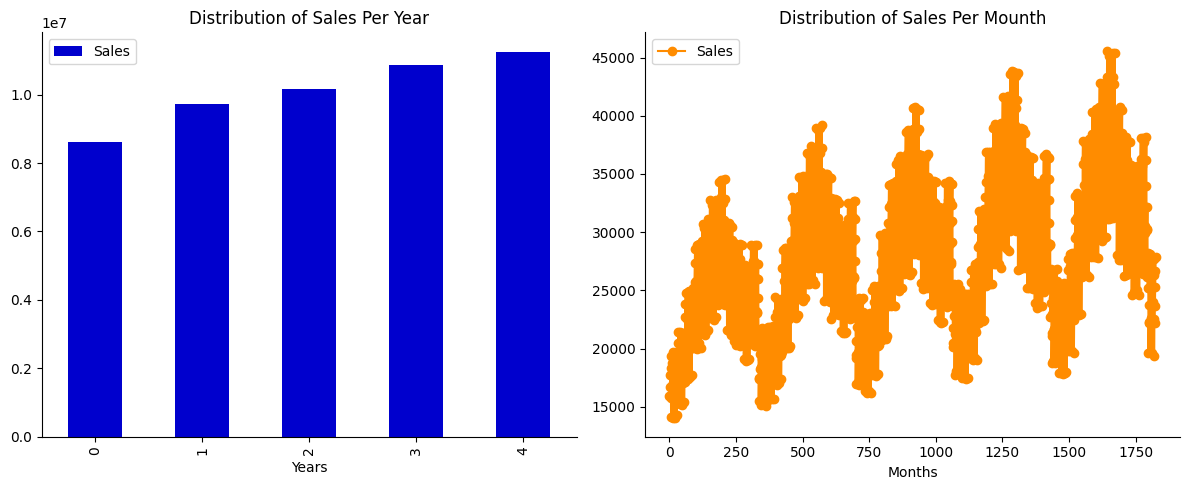

In [14]:
layout = (1, 2)

raw = plt.subplot2grid(layout, (0 ,0))
law = plt.subplot2grid(layout, (0 ,1))

years = y_df['sales'].plot(kind = "bar",color = 'mediumblue', label="Sales",ax=raw, figsize=(12,5))
months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

years.set(xlabel = "Years",title = "Distribution of Sales Per Year")
months.set(xlabel = "Months", title = "Distribution of Sales Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()


<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <p style="padding: 15px;
              color:black;">📌 If we plot the total monthly sales over time, we see that the average monthly sales increase over time, so our data is not stationary.
    </p>
</div>

[🦎 TREND AND SEASONALITY](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)
> There are many other models to forecast time series, such as weighted
moving average models or autoregressive integrated moving average
(ARIMA) models. Some of them require you to first remove the trend
and seasonality. For example, if you are studying the number of active
users on your website, and it is growing by 10% every month, you
would have to remove this trend from the time series. Once the model
is trained and starts making predictions, you would have to add the
trend back to get the final predictions. Similarly, if you are trying to
predict the amount of sunscreen lotion sold every month, you will
probably observe strong seasonality: since it sells well every summer,
a similar pattern will be repeated every year. You would have to
remove this seasonality from the time series, for example by
computing the difference between the value at each time step and the
value one year earlier (this technique is called differencing). Again,
after the model is trained and makes predictions, you would have to
add the seasonal pattern back to get the final predictions.


# **Data Exploration (EDA)**

 To make it stationary, we will calculate the difference between the sales of each month and add it to our data frame as a new column.
> Further details of the stationary and differences are available [here.](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) But first let's take a closer look at the data set you work with by learning more about the data.

In [15]:
def sales_time(data):
    """Time interval of dataset:"""

    data.date = pd.to_datetime(data.date)
    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")


In [16]:
sales_time(df_s)

Days: 1825
Years: 5
Month: 60


**Sales Data Per Store**

In [17]:
# Let's sell it per store:

def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    #print(sales_by_store)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=sales_by_store.store, y=sales_by_store.sales, color='darkred')
    
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    
    return sales_by_store
    

,store,sales
0,1,4717729.0
1,2,6349225.0
2,3,5757752.0
3,4,5153048.0
4,5,3958792.0
5,6,3976146.0
6,7,3680862.0
7,8,6110899.0
8,9,5243177.0
9,10,5659639.0


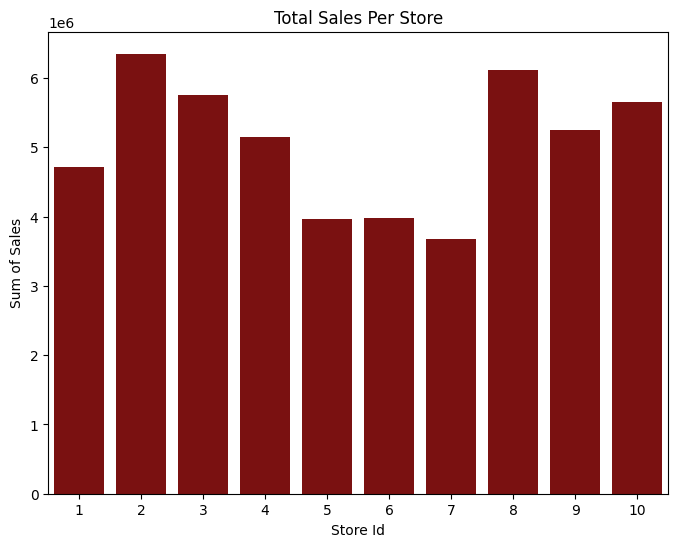

In [18]:
sales_per_store(df_s)


**Mean Monthly Sales**

In [19]:
# Overall for 5 years:

average_m_sales = m_df.sales.mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

def avarage_12months():
# Last 1 years (this will be the forecasted sales):
    average_m_sales_1y = m_df.sales[-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
avarage_12months()

Overall Avarage Monthly Sales: $27714.824205914567
Last 12 months average monthly sales: $24432.25


# **Determining Time Series Stationary**

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented in this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

In [20]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    
    sns.lineplot(x=x_col, y=y_col,data = data, ax = ax, color = 'darkblue', label='Total Sales')
    
    s_mean = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date, format='%Y')
    sns.lineplot(x=(s_mean.date + datetime.timedelta(6*365/12)), y= y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Years",
           ylabel = "Sales",
           title = title)


In [21]:
#TypeError: lineplot() got multiple values for argument 'data'
#specifically mention x = and y = 

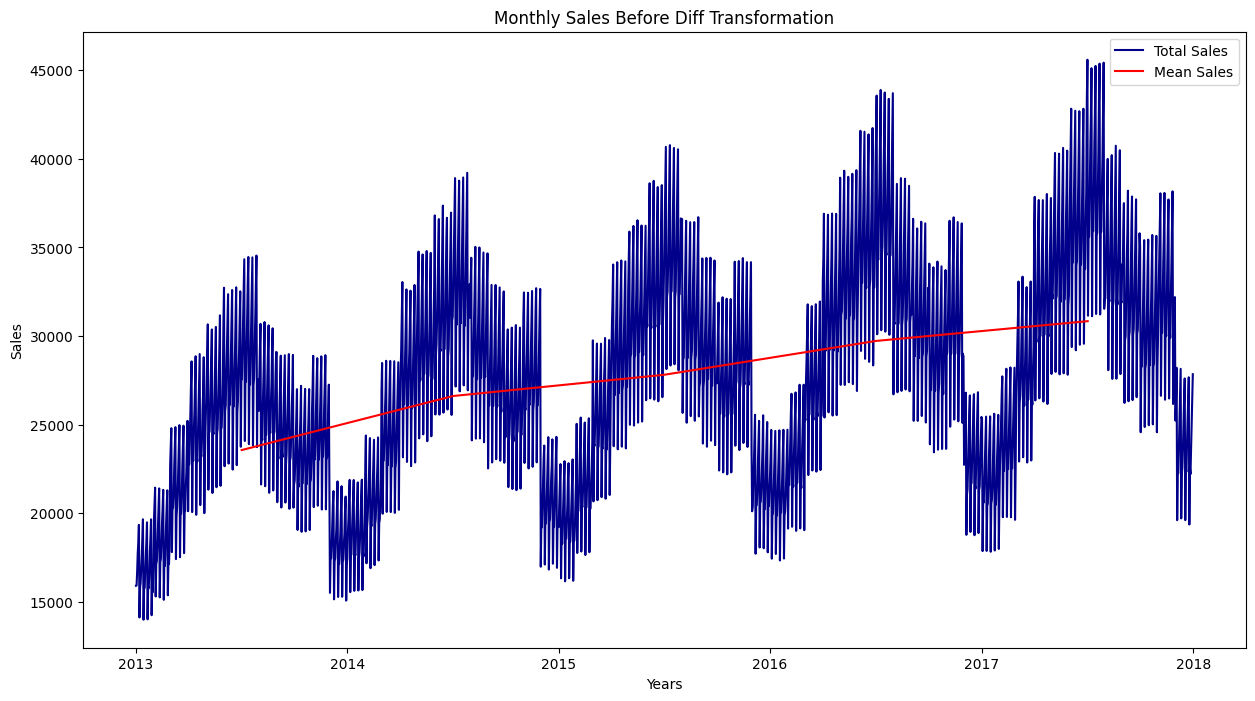

In [22]:
time_plot(m_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation' )

* **Differencing**

In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. 

In [23]:
def get_diff(data):
    """Calculate the difference in sales month over month:"""
    
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('./stationary_df.csv')
    
    return data


In [24]:
m_df.head(10)

,date,sales
0,2013-01-01,15914.0
1,2013-01-02,15925.0
2,2013-01-03,16702.0
3,2013-01-04,17759.0
4,2013-01-05,18343.0
5,2013-01-06,19348.0
6,2013-01-07,14127.0
7,2013-01-08,15781.0
8,2013-01-09,16101.0
9,2013-01-10,16831.0


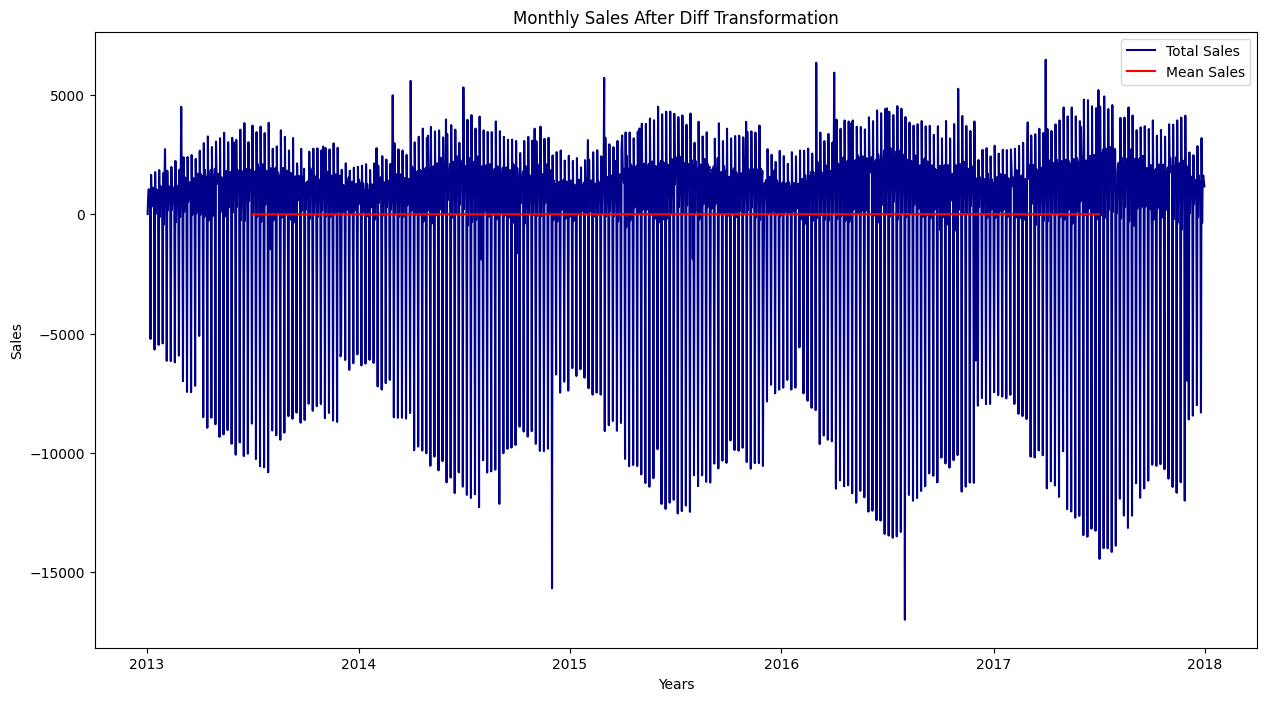

In [25]:
stationary_df = get_diff(m_df)
time_plot(stationary_df, 'date', 'sales_diff', 
          'Monthly Sales After Diff Transformation')

In [26]:
stationary_df[11:20]

,date,sales,sales_diff
12,2013-01-13,19665.0,926.0
13,2013-01-14,14000.0,-5665.0
14,2013-01-15,15772.0,1772.0
15,2013-01-16,15799.0,27.0
16,2013-01-17,16840.0,1041.0
17,2013-01-18,17666.0,826.0
18,2013-01-19,18488.0,822.0
19,2013-01-20,19494.0,1006.0
20,2013-01-21,14022.0,-5472.0


<div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <p style="padding: 15px;
              color:black;">📌 Based on the above, we will choose our look-back period to be 12 months. We will, therefore, generate a data frame that has 13 columns, 1 column for each of the 12 months and the column for our dependent variable, difference in sales.
    </p>
</div>


# Regressive Modeling

> Let's create a CSV file where each row represents a month and the columns will have sales, dependent variables, and previous sales for each delay. The 12 delay properties are created according to the EDA. Data is used for regression modeling.


Code was taken from [Baris Karaman’s 'Data Driven Growth' series.](https://towardsdatascience.com/predicting-sales-611cb5a252de)

In [27]:
# Let's create a data frame for transformation from time series to supervised:

def built_supervised(data):
    supervised_df = data.copy()

    # Create column for each lag:
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    # Drop null values:
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('./model_df.csv', index=False)
    
    return supervised_df
    

In [28]:
model_df = built_supervised(stationary_df)
model_df 

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013-01-14,14000.0,-5665.0,926.0,1119.0,789.0,730.0,320.0,1654.0,-5221.0,1005.0,584.0,1057.0,777.0,11.0
1,2013-01-15,15772.0,1772.0,-5665.0,926.0,1119.0,789.0,730.0,320.0,1654.0,-5221.0,1005.0,584.0,1057.0,777.0
2,2013-01-16,15799.0,27.0,1772.0,-5665.0,926.0,1119.0,789.0,730.0,320.0,1654.0,-5221.0,1005.0,584.0,1057.0
3,2013-01-17,16840.0,1041.0,27.0,1772.0,-5665.0,926.0,1119.0,789.0,730.0,320.0,1654.0,-5221.0,1005.0,584.0
4,2013-01-18,17666.0,826.0,1041.0,27.0,1772.0,-5665.0,926.0,1119.0,789.0,730.0,320.0,1654.0,-5221.0,1005.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2017-12-27,22212.0,-353.0,3194.0,-8303.0,1369.0,1062.0,1248.0,1641.0,-120.0,2858.0,-7993.0,1159.0,1252.0,1444.0
1809,2017-12-28,23658.0,1446.0,-353.0,3194.0,-8303.0,1369.0,1062.0,1248.0,1641.0,-120.0,2858.0,-7993.0,1159.0,1252.0
1810,2017-12-29,25288.0,1630.0,1446.0,-353.0,3194.0,-8303.0,1369.0,1062.0,1248.0,1641.0,-120.0,2858.0,-7993.0,1159.0
1811,2017-12-30,26675.0,1387.0,1630.0,1446.0,-353.0,3194.0,-8303.0,1369.0,1062.0,1248.0,1641.0,-120.0,2858.0,-7993.0


In [29]:
model_df.info() # Supervised Dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1813 non-null   datetime64[ns]
 1   sales       1813 non-null   float64       
 2   sales_diff  1813 non-null   float64       
 3   lag_1       1813 non-null   float64       
 4   lag_2       1813 non-null   float64       
 5   lag_3       1813 non-null   float64       
 6   lag_4       1813 non-null   float64       
 7   lag_5       1813 non-null   float64       
 8   lag_6       1813 non-null   float64       
 9   lag_7       1813 non-null   float64       
 10  lag_8       1813 non-null   float64       
 11  lag_9       1813 non-null   float64       
 12  lag_10      1813 non-null   float64       
 13  lag_11      1813 non-null   float64       
 14  lag_12      1813 non-null   float64       
dtypes: datetime64[ns](1), float64(14)
memory usage: 212.6 KB


## **Functions For Modeling** 

To create and assess all of our models, we will use a series of helper functions that perform the following functions:
* *Train test split*
* *Scale the data*
* *Reverse scaling*
* *Create a predictions data frame*
* *Score the models*


 # Train Test Split

>       We detach our data so that the last 12 months are part of the test set and the rest of the data is used to train our model.

In [30]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-12].values, data[-12:].values
    
    return train, test

train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)


 # Scale The Data

>      Using a min-max scaler, we will scale the data so that all of our variables fall within the range of -1 to 1.

In [31]:
train

array([[-5665.,   926.,  1119., ...,  1057.,   777.,    11.],
       [ 1772., -5665.,   926., ...,   584.,  1057.,   777.],
       [   27.,  1772., -5665., ...,  1005.,   584.,  1057.],
       ...,
       [ 1159.,  1252.,  1444., ...,  1475.,    54.,  2594.],
       [-7993.,  1159.,  1252., ...,  1584.,  1475.,    54.],
       [ 2858., -7993.,  1159., ...,  1273.,  1584.,  1475.]])

In [32]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""
    
    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    print(f"Shape of  Train: {train_set_scaled.shape}\nShape of  Test: {test_set_scaled.shape}")
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)
Shape of X Train: (1801, 12)
Shape of y Train: (1801,)
Shape of X Test: (12, 12)
Shape of y Test: (12,)


 # Reverse Scaling
>       After running our models, we will use this helper function to reverse the scaling of step 2.

In [33]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on predictions."""
   # y_pred: model predictions
   # x_test: features from the test set used for predictions
   # scaler_obj: the scaler objects used for min-max scaling
   # lstm: indicate if the model run is the lstm. If True, additional transformation occurs 
    
    # Reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted
    


 # Predictions Dataframe
>     Generate a dataframe that includes the actual sales captured in our test set and the predicted results from our model so that we can quantify our success.

In [34]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted sales for each month
    for plotting results."""
    
    # unscale_predictions: the model predictions that do not have min-max or other scaling applied
    # origin_df: the original monthly sales dataframe
    
    # Create dataframe that shows the predicted sales:
    result_list = []
    sales_dates = list(origin_df[-13:].date)
    act_sales = list(origin_df[-13:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

# Graph of Results

In [35]:
def plot_results(results, origin_df, model_name):
# results: a dataframe with unscaled predictions

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=origin_df.date, y=origin_df.sales, data=origin_df, ax=ax, 
                 label='Original', color='blue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='red')
    
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend(loc='best')
    
    filepath = Path('./model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'./model_output/{model_name}_forecasting.svg')

# Score Models

In [36]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:], 
                                      unscale_df.pred_value[-12:]))
    
    mae = mean_absolute_error(origin_df.sales[-12:], 
                              unscale_df.pred_value[-12:])
    
    r2 = r2_score(origin_df.sales[-12:], 
                  unscale_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [37]:
def regressive_model(train_data, test_data, model, model_name):
    """Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved."""
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)
    return mod, unscaled_df

# **Modeling**
# Regressive Models
* Linear Regression
* Random Forest Regressor
* XGBoost

# [Linear Regression](http://)

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)
RMSE: 308.92785026065013
MAE: 285.4166666666667
R2 Score: 0.9839238724217021


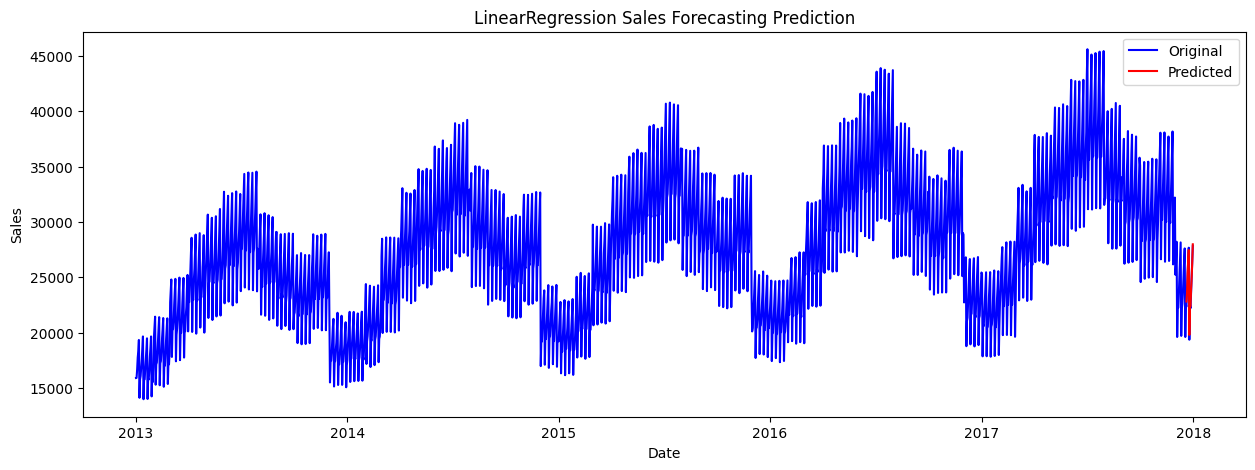

In [40]:
lin_reg, unscaled_data = regressive_model(train, test, LinearRegression(), 'LinearRegression')

In [41]:
# write arima pkl file
filename = "linear_regression_trained_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(lin_reg, file)

In [42]:
pd.DataFrame(train).to_csv('train_data.csv', index=False)

In [43]:
pd.DataFrame(test).to_csv('test_data.csv', index=False)

In [44]:
dates = m_df.date[-12:].values
orig_sales = m_df.sales[-12:].values
pred_sales = unscaled_data.pred_value[-12:].values

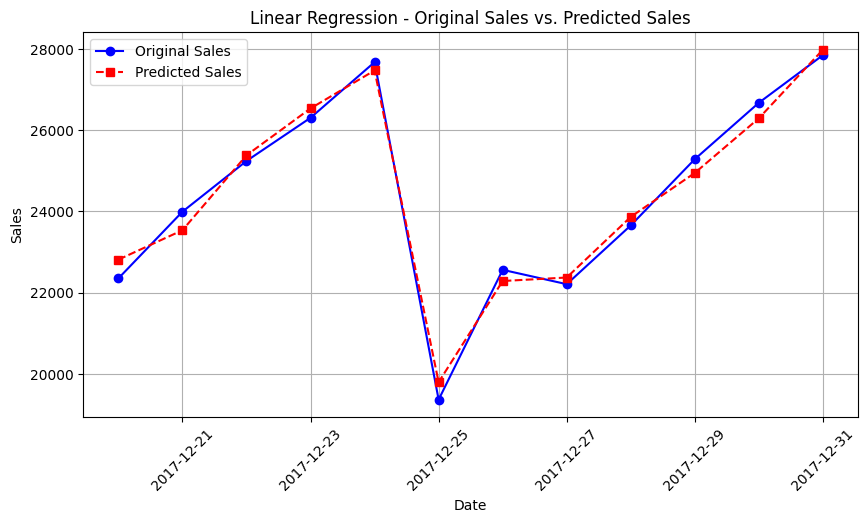

In [46]:
# Sample data (replace with actual sales data)
#dates = pd.date_range(start="2023-01-01", periods=10, freq="D")  # Example dates
#orig_sales = [120, 135, 150, 165, 180, 175, 190, 205, 195, 210]  # Replace with actual values
#pred_sales = [118, 140, 145, 160, 185, 170, 185, 200, 190, 205]  # Replace with model predictions

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(dates, orig_sales, marker="o", linestyle="-", color="blue", label="Original Sales")
plt.plot(dates, pred_sales, marker="s", linestyle="--", color="red", label="Predicted Sales")

# Labels and Title
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Linear Regression - Original Sales vs. Predicted Sales")
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.show()

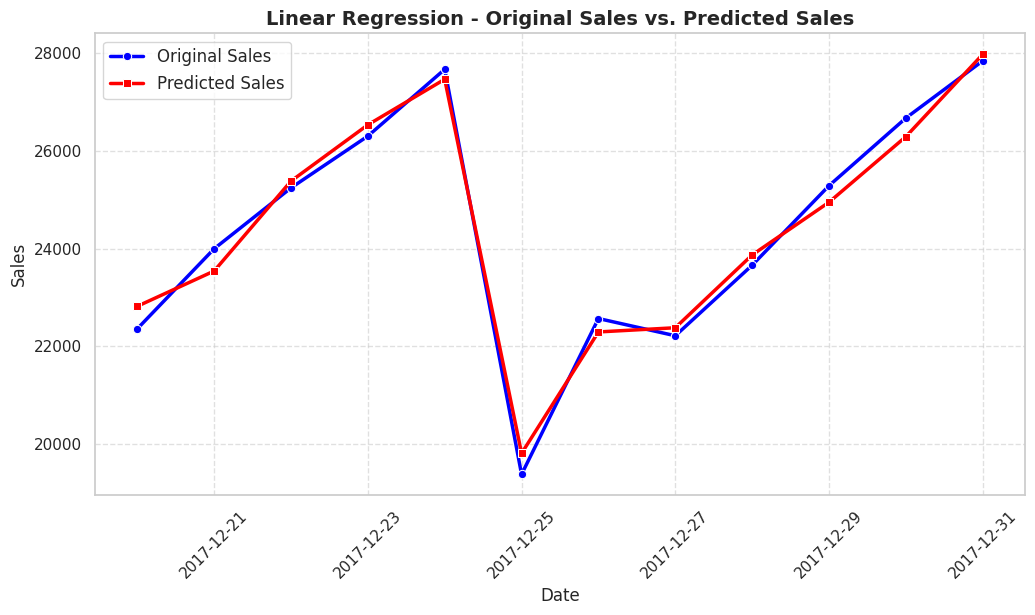

<Figure size 640x480 with 0 Axes>

In [47]:
df = pd.DataFrame({"Date": dates, "Original Sales": orig_sales, "Predicted Sales": pred_sales})

# Set the theme for a sophisticated look
sns.set_theme(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Original Sales", data=df, marker="o", label="Original Sales", linewidth=2.5, color="blue")
sns.lineplot(x="Date", y="Predicted Sales", data=df, marker="s", label="Predicted Sales", linewidth=2.5, color="red")

# Customizing the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("Linear Regression - Original Sales vs. Predicted Sales", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()
plt.savefig(f'./model_output/linear_reg_zoom_origvspred_sales.svg')

 # [ Random Forest Regressor ](https://scikit-learn.org/0.24/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest%20reg#sklearn.ensemble.RandomForestRegressor)

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)
RMSE: 257.2746586821174
MAE: 197.25
R2 Score: 0.9888503472719855


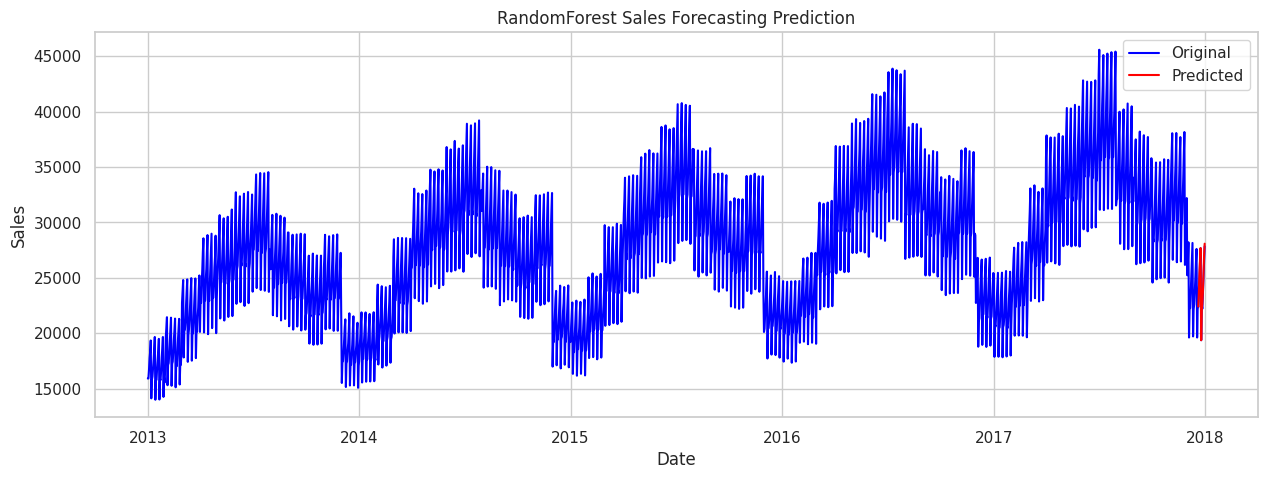

In [48]:
rndm_forest, unscaled_data =regressive_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

In [49]:
# write arima pkl file
filename = "random_forest_trained_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(rndm_forest, file)

In [50]:
dates = m_df.date[-12:].values
orig_sales = m_df.sales[-12:].values
pred_sales = unscaled_data.pred_value[-12:].values

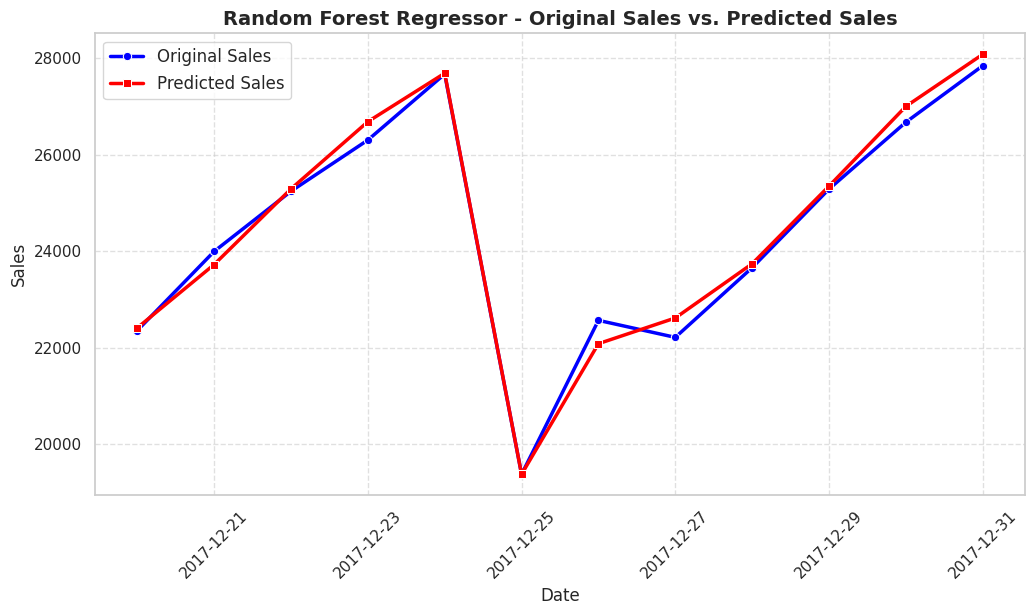

<Figure size 640x480 with 0 Axes>

In [51]:
df = pd.DataFrame({"Date": dates, "Original Sales": orig_sales, "Predicted Sales": pred_sales})

# Set the theme for a sophisticated look
sns.set_theme(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Original Sales", data=df, marker="o", label="Original Sales", linewidth=2.5, color="blue")
sns.lineplot(x="Date", y="Predicted Sales", data=df, marker="s", label="Predicted Sales", linewidth=2.5, color="red")

# Customizing the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("Random Forest Regressor - Original Sales vs. Predicted Sales", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()
plt.savefig(f'./model_output/rndm_forest_zoom_origvspred_sales.svg')

# [  XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html)

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)
RMSE: 247.41665263276036
MAE: 206.0
R2 Score: 0.9896884210024073


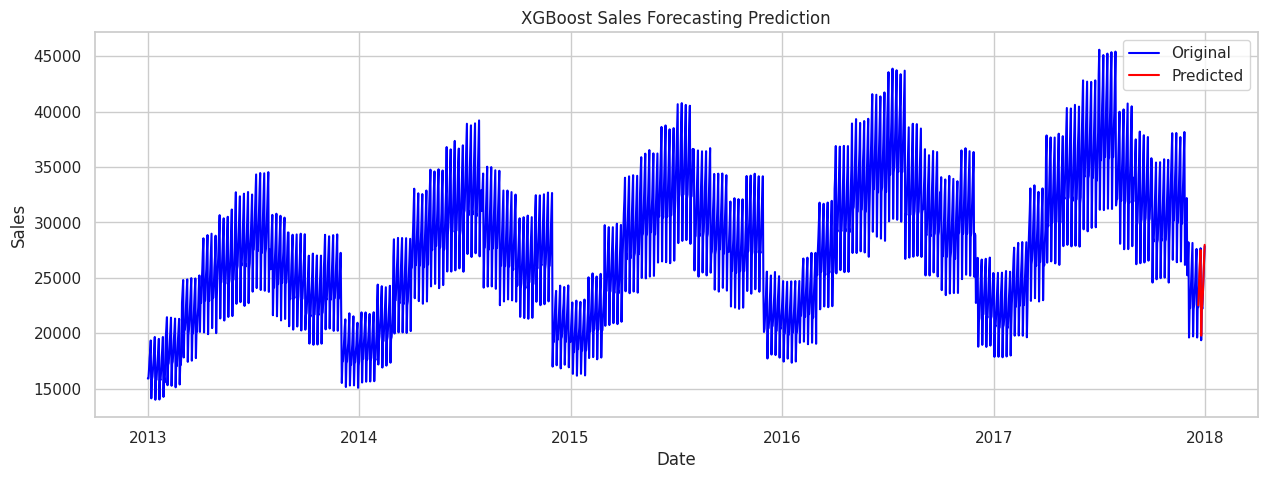

In [52]:
xgboost_model, unscaled_data = regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

In [53]:
# write arima pkl file
filename = "XGBoost_trained_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(xgboost_model, file)

In [54]:
dates = m_df.date[-12:].values
orig_sales = m_df.sales[-12:].values
pred_sales = unscaled_data.pred_value[-12:].values

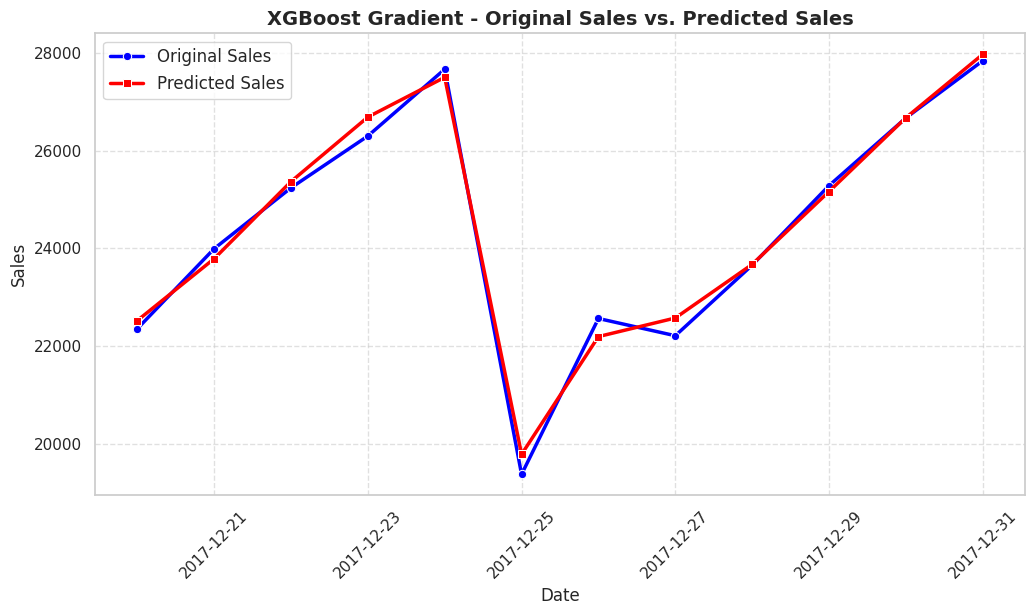

<Figure size 640x480 with 0 Axes>

In [55]:
df = pd.DataFrame({"Date": dates, "Original Sales": orig_sales, "Predicted Sales": pred_sales})

# Set the theme for a sophisticated look
sns.set_theme(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Original Sales", data=df, marker="o", label="Original Sales", linewidth=2.5, color="blue")
sns.lineplot(x="Date", y="Predicted Sales", data=df, marker="s", label="Predicted Sales", linewidth=2.5, color="red")

# Customizing the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("XGBoost Gradient - Original Sales vs. Predicted Sales", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()
plt.savefig(f'./model_output/rndm_forest_zoom_origvspred_sales.svg')

In [ ]:
#Add 3-4 more models
#buid coorelation graphs
#build presentive and influential graphs
#Neurals 
#classifaction AUC ROC


# [SVM Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)
RMSE: 353.2828187161102
MAE: 298.75
R2 Score: 0.9789761449772801


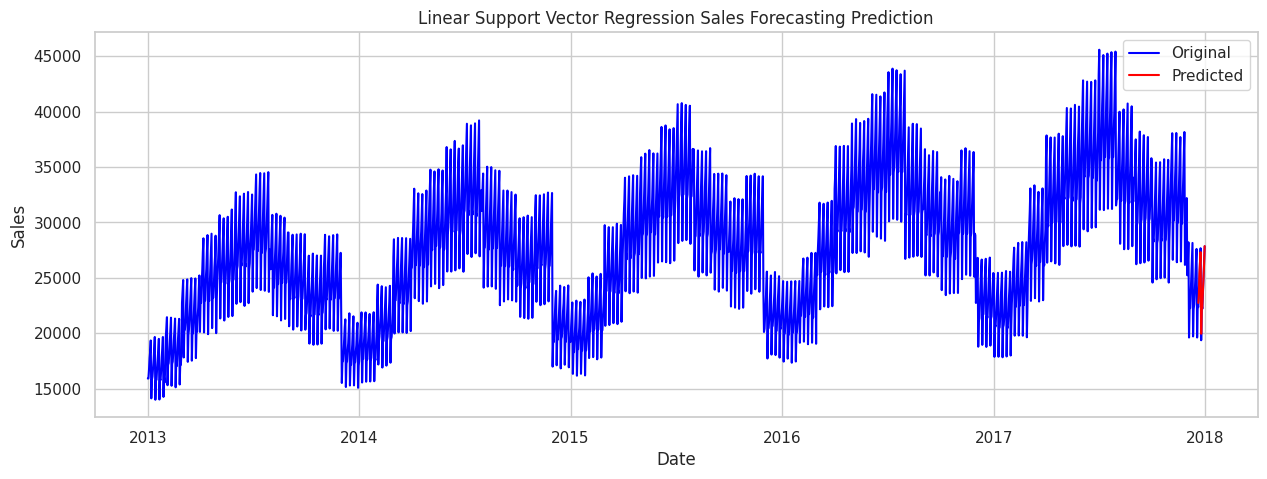

In [60]:
svm_reg, unscaled_data = regressive_model(train, test, SVR(kernel='linear'), 
          'Linear Support Vector Regression')

In [61]:
# write arima pkl file
filename = "SVM_regression_trained_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(svm_reg, file)

In [62]:
dates = m_df.date[-12:].values
orig_sales = m_df.sales[-12:].values
pred_sales = unscaled_data.pred_value[-12:].values

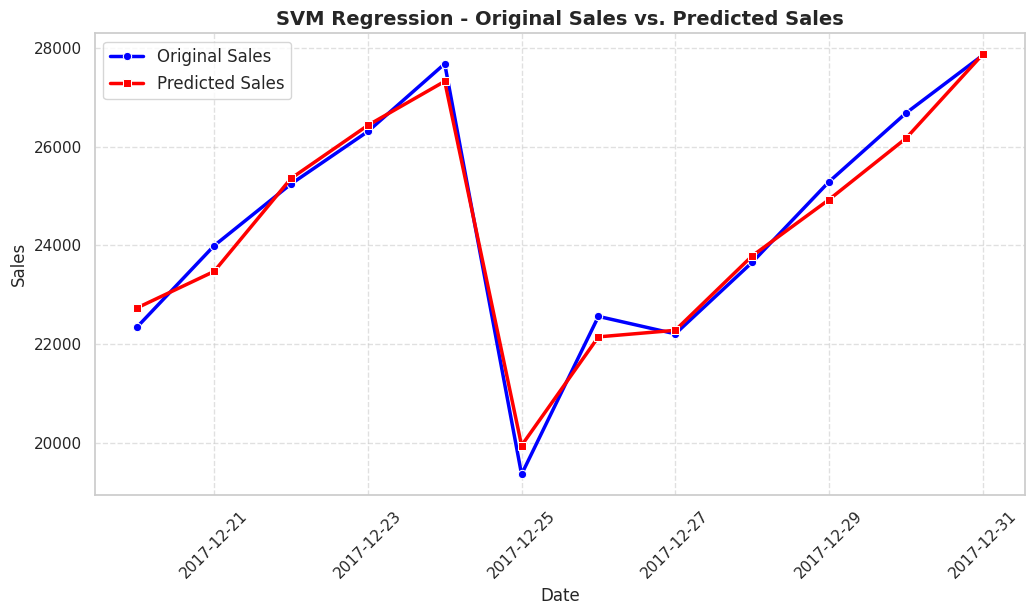

<Figure size 640x480 with 0 Axes>

In [63]:
df = pd.DataFrame({"Date": dates, "Original Sales": orig_sales, "Predicted Sales": pred_sales})

# Set the theme for a sophisticated look
sns.set_theme(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Original Sales", data=df, marker="o", label="Original Sales", linewidth=2.5, color="blue")
sns.lineplot(x="Date", y="Predicted Sales", data=df, marker="s", label="Predicted Sales", linewidth=2.5, color="red")

# Customizing the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("SVM Regression - Original Sales vs. Predicted Sales", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()
plt.savefig(f'./model_output/svm_reg_zoom_origvspred_sales.svg')

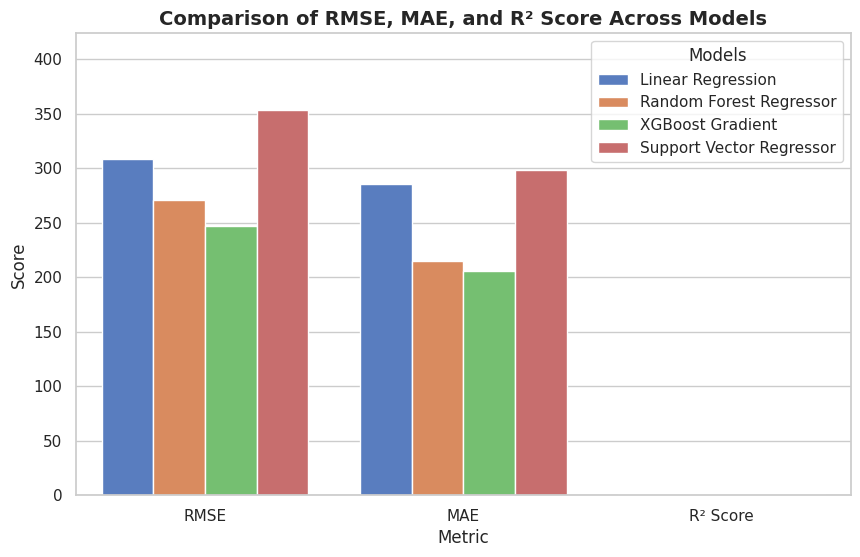

In [65]:
#compare the 3 models built so far. 
# Evaluate all models
metrics = {
    "Model": ["Linear Regression", "Random Forest Regressor", "XGBoost Gradient", "Support Vector Regressor"],
    "RMSE": [308.9278503, 270.67231110, 247.416652633, 353.28281872],
    "MAE": [285.4166667, 215.16666667, 206.0, 298.75],
    "R² Score": [0.983923872, 0.9876588684, 0.98968842100, 0.9789761449]
}
# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Melt DataFrame for Seaborn visualization
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Plot the comparison
plt.figure(figsize=(10, 6))
#sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="muted")
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="muted")

# Customize the plot
plt.title("Comparison of RMSE, MAE, and R² Score Across Models", fontsize=14, fontweight="bold")
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Models")
plt.ylim(0, max(df_melted["Score"]) * 1.2)  # Adjust y-axis for better visualization

# Show the plot
plt.show()

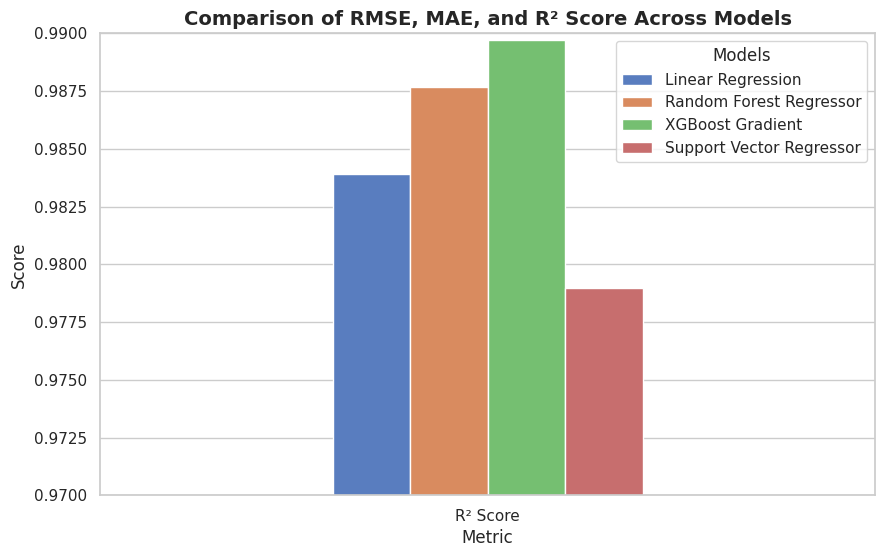

In [73]:
#compare the 3 models built so far. 
# Evaluate all models
metrics = {
    "Model": ["Linear Regression", "Random Forest Regressor", "XGBoost Gradient", "Support Vector Regressor"],
    "R² Score": [0.983923872, 0.9876588684, 0.98968842100, 0.9789761449]
}
# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Melt DataFrame for Seaborn visualization
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Plot the comparison
plt.figure(figsize=(10, 6))
#sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="muted")
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="muted", width=0.4)

# Customize the plot
plt.title("Comparison of RMSE, MAE, and R² Score Across Models", fontsize=14, fontweight="bold")
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Models")
plt.ylim(0.970, 0.99)  # Adjust y-axis for better visualization

# Show the plot
plt.show()

# LSTM 

LSTM is a type of recurring neural network that is especially useful for predicting sequential data. Getting started with the Keras Sequential model

https://faroit.com/keras-docs/1.2.0/getting-started/sequential-model-guide/#sequence-classification-with-lstm

In [77]:
def lstm_model(train_data, test_data):
    """Runs a long-short-term-memory neural net with 2 dense layers. 
    Generates predictions that are then unscaled. 
    Scores are printed and the results are plotted and saved."""
    # train_data: dataset used to train the model
    # test_data: dataset used to test the model
   
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    
    # Build LSTM:
    
    model = Sequential()
    model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(LSTM(4, input(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    #model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, 
              shuffle=False)
    
    #model = Sequential([
    #LSTM(50, activation='relu', return_sequences=True, input_shape=( X_train.shape[1], X_train.shape[2])),
     # Output layer
    #])
    
    predictions = model.predict(X_test,batch_size=1)
    
    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = prediction_df(unscaled, origin_df)
    
    get_scores(unscaled_df, origin_df, 'LSTM')
    plot_results(unscaled_df, origin_df, 'LSTM')
    return model, unscaled_df

Shape of  Train: (1801, 13)
Shape of  Test: (12, 13)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0640
Epoch 2/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0047
Epoch 3/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0044
Epoch 4/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0042
Epoch 5/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0040
Epoch 6/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0039
Epoch 7/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0038
Epoch 8/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0038
Epoch 9/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0037
Epoch 10/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 - loss: 0.0036
Epoch 11/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 8.7884e-05 -

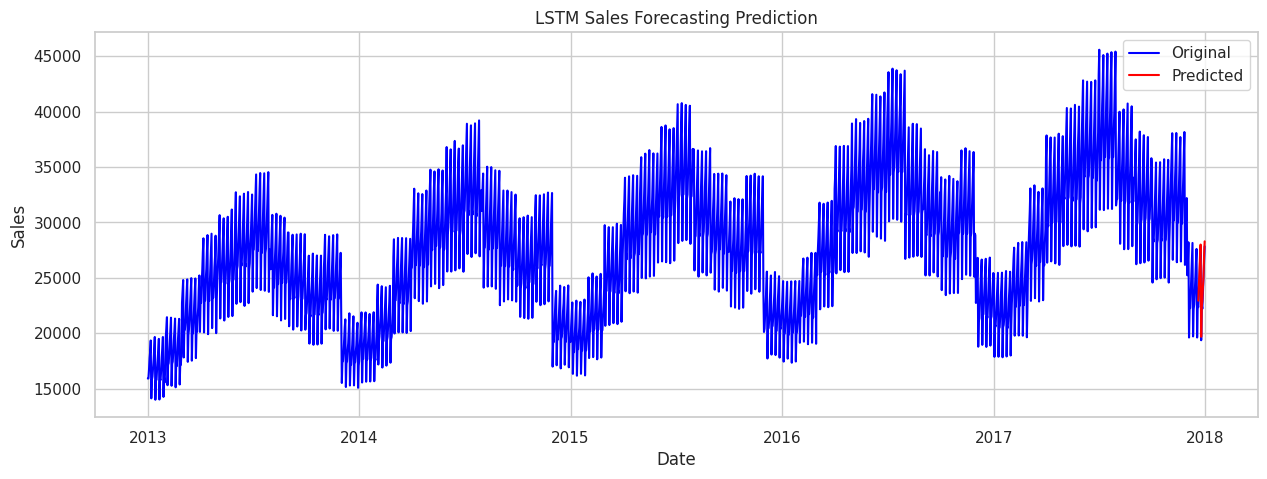

In [78]:
lstm_model,nscaled_data  = lstm_model(train,test)

In [80]:
# write lstm pkl file
filename = "lstm_trained_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(lstm_model, file)

In [81]:
dates = m_df.date[-12:].values
orig_sales = m_df.sales[-12:].values
pred_sales = unscaled_data.pred_value[-12:].values

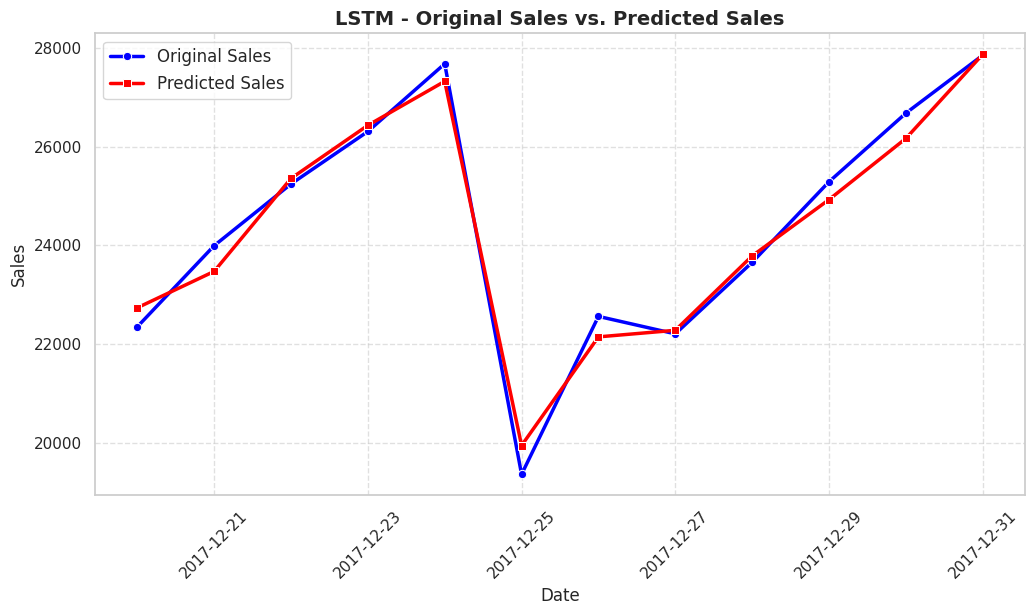

<Figure size 640x480 with 0 Axes>

In [82]:
df = pd.DataFrame({"Date": dates, "Original Sales": orig_sales, "Predicted Sales": pred_sales})

# Set the theme for a sophisticated look
sns.set_theme(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Original Sales", data=df, marker="o", label="Original Sales", linewidth=2.5, color="blue")
sns.lineplot(x="Date", y="Predicted Sales", data=df, marker="s", label="Predicted Sales", linewidth=2.5, color="red")

# Customizing the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.title("LSTM - Original Sales vs. Predicted Sales", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()
plt.savefig(f'./model_output/lstm_model_zoom_origvspred_sales.svg')

# ARIMA Modeling

For our Arima model, we will need only a datetime index and the dependent variable (diff in sales) columns.

In [38]:
def build_arima_data(data):
    """Generates a csv-file with a datetime index and a dependent sales column for ARIMA modeling."""
    
    da_data = data.set_index('date').drop('sales', axis=1)
    da_data.dropna(axis=0)
    
    da_data.to_csv('./arima_df.csv')
    
    return da_data

In [39]:
datatime_df = build_arima_data(stationary_df)
datatime_df # ARIMA Dataframe

,sales_diff
date,
2013-01-02,11.0
2013-01-03,777.0
2013-01-04,1057.0
2013-01-05,584.0
2013-01-06,1005.0
...,...
2017-12-27,-353.0
2017-12-28,1446.0
2017-12-29,1630.0


In [44]:
# datatime_df.dropna(inplace=True)
# Remove NaN values and reset index
datatime_df.dropna(inplace=True)
#datatime_df.reset_index(drop=True, inplace=True)

**Observing Lags** 

For our other models, we will create a new data frame where each feature represents a previous month’s sales. To determine how many months to include in our feature set, we will observe the autocorrelation and partial autocorrelation plots and use the rules for selecting lags in ARIMA modeling. This way, we can keep consistent a look-back period for our ARIMA and regressive models.

 ### Statsmodels
 
https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

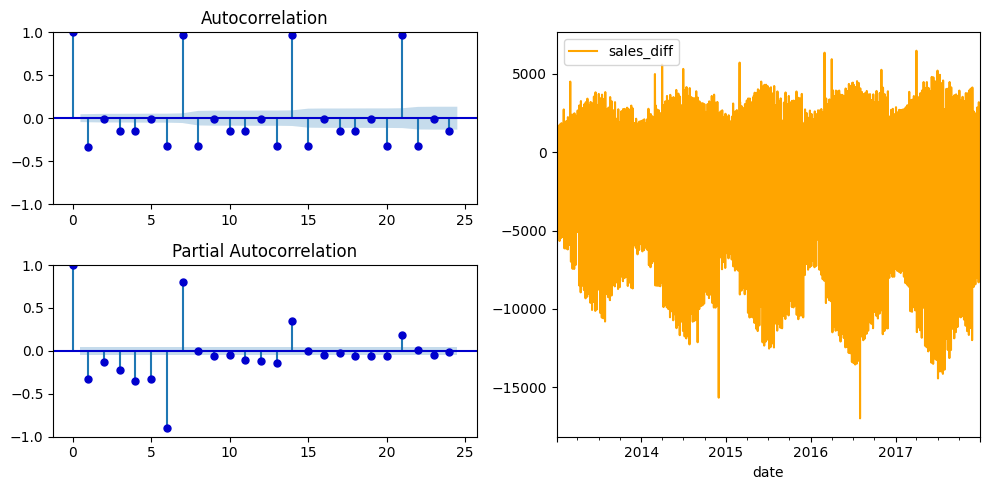

In [45]:
def plots_lag(data, lags=None):
    """Convert dataframe to datetime index"""
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    
    dt_data.plot(ax=law, figsize=(10, 5), color='orange')
    # Plot the autocorrelation function:
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    
    # Will also adjust spacing between subplots to minimize the overlaps:
    plt.tight_layout()

plots_lag(stationary_df, lags=24);

# ARIMA Modeling

## SARIMAX Modeling

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

We use the statsmodels SARIMAX package to train the model and generate dynamic predictions. The SARIMA model breaks down into a few parts.


*  AR: represented as p, is the autoregressive model
*  I : represented as d, is the differencing term
*  MA: represented as q, is the moving average model
*  S: enables us to add a seasonal component


📌 In the code below, we define our model and then make dynamic predictions for the last 12 months of the data. For standard, non-dynamic predictions, the following month’s prediction is made using the actual sales from the prior months. In contrast, for dynamic predictions, the following month’s prediction is made using the predicted sales from the prior months.

In [46]:
def sarimax_model(data):
    # Model:
    sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12, 0, 0),
                                    seasonal_order=(0, 1, 0, 12),
                                    trend='c').fit()
    
    # Generate predictions:
    start, end, dynamic = 40, 100, 7
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start+dynamic:end]
    
    data[["sales_diff","pred_value"]].plot(color=['blue', 'Red'])
    plt.legend(loc='upper left')
    
    model_score = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.pred_value[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.pred_value[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.pred_value[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")
    
    return sar, data, pred_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 937.9518646653171
MAE: 713.0811112474439
R2 Score: 0.9169801656769564


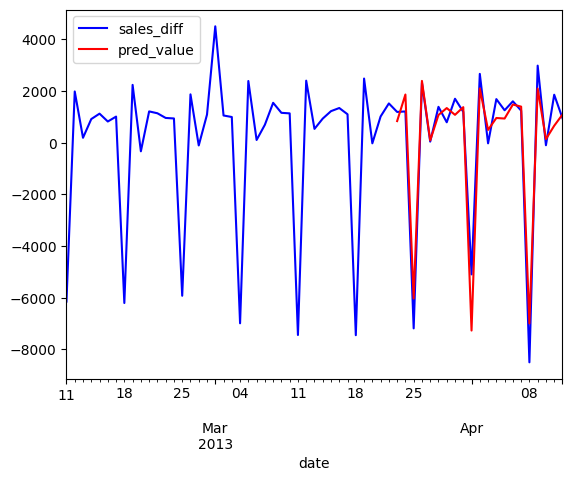

In [47]:
sar, datatime_df, predictions = sarimax_model(datatime_df)

In [48]:
# write arima pkl file
filename = "arima_trained_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(sar, file)